In [50]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [51]:
torch.cuda.set_device(0)
# specify dtype
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
print(torch.cuda.device_count())

True
1


In [52]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-5
momentum = 0.9
num_epoch = 30
show_every = 2000

In [53]:
net = models.vgg16(pretrained=True).type(dtype)

In [55]:
new_classifier = nn.Sequential(nn.Linear(512, 512),
                              nn.ReLU(inplace=True),
                              nn.Dropout(0.5),
                              nn.Linear(512, 10)).type(dtype)

In [56]:
net.classifier = new_classifier
net

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [57]:
#list(net.features.children())

In [58]:
x = Variable(torch.randn(1, 3, 32, 32)).type(dtype)
net(x)

Variable containing:
 0.1031 -0.0665  0.1951  0.1562 -0.0653  0.5350 -0.2878 -0.1224 -0.9626 -0.3045
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

In [15]:
# Data
print('==> Preparing data..')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/data/put_data/frank840925/IDP/data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='/data/put_data/frank840925/IDP/data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(trainset.__len__())
print(testset.__len__())

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [16]:
#import time
#s = time.time()
#for i, (image, label) in enumerate(trainloader):
#    print(time.time()-s)
#    s=time.time()

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plot_losses(loss_history1=None, loss_history2=None):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if loss_history1:
        ax1.plot(loss_history1, color="blue", label="train")
    if loss_history2:
        ax1.plot(loss_history2, color="green", label="test")
    #ax2 = ax1.twinx()
    #ax2.set_yscale('log')
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Cross-entropy loss")
    plt.savefig('output_losses.png')

def plot_accuracy(accuracy1=None, accuracy2=None):
    plt.clf()
    fig2 = plt.figure()
    ax1 = fig2.add_subplot(111)
    if accuracy1:
        ax1.plot(accuracy1, color="red", label="train")
    if accuracy2:
        ax1.plot(accuracy2, color="black", label="test")
    plt.xlabel("epoch") 
    plt.ylabel("accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Train/Test accuracy") 
    plt.savefig('accuracy.png')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
#imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

torch.Size([32, 3, 32, 32])


In [18]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([{'params': net.features.parameters()},
           {'params': net.classifier.parameters(), 'lr': 1e-4}], lr=learning_rate, momentum=momentum)

In [19]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

# start training
for epoch in range(num_epoch):  # loop over the dataset multiple times
    running_loss1 = []
    running_loss2 = []
    running_correct1=[]
    running_correct2=[]
    for i, data in enumerate(trainloader, 0):
        correct = 0
        net.train(True)
        # get the inputs
        inputs, labels = data
        # wrap them in Variable
        inputs, labels = Variable(inputs).type(dtype), Variable(labels).type(torch.cuda.LongTensor)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        # loss
        running_loss1.append(loss.data[0])
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
        correct = correct/labels.size(0)*100
        running_correct1.append(correct)
        
    for i, tdata in enumerate(testloader, 0):
        test_correct = 0
        net.train(False)
        tinputs, tlabels = tdata
        tinputs, tlabels = Variable(tinputs).type(dtype), Variable(tlabels).type(torch.cuda.LongTensor)
        toutput = net(tinputs)
        tloss = criterion(toutput, tlabels)
        running_loss2.append(tloss.data[0])
        _, tpredicted = torch.max(toutput.data, 1)
        test_correct += (tpredicted == tlabels.data).sum()
        test_correct = test_correct/tlabels.size(0)*100
        running_correct2.append(test_correct)
    
    train_loss.append(np.mean(running_loss1))
    test_loss.append(np.mean(running_loss2))
    train_acc.append(np.mean(running_correct1))
    test_acc.append(np.mean(running_correct2))
    
    #statistics
    print('Epoch [%d/%d], Loss: %.4f, Train Accuracy: %r percent' 
                %(epoch+1, num_epoch, train_loss[-1], train_acc[-1]))

print('Finished Training')

Epoch [1/30], Loss: 1.7313, Train Accuracy: 40.279110684580935 percent
Epoch [2/30], Loss: 1.0467, Train Accuracy: 62.983845169545745 percent
Epoch [3/30], Loss: 0.8742, Train Accuracy: 69.375799744081888 percent
Epoch [4/30], Loss: 0.7847, Train Accuracy: 72.616762635956491 percent
Epoch [5/30], Loss: 0.7253, Train Accuracy: 74.570137555982086 percent
Epoch [6/30], Loss: 0.6856, Train Accuracy: 76.113643634037103 percent
Epoch [7/30], Loss: 0.6529, Train Accuracy: 77.049344209852848 percent
Epoch [8/30], Loss: 0.6239, Train Accuracy: 78.202975047984651 percent
Epoch [9/30], Loss: 0.6001, Train Accuracy: 78.818777991042865 percent
Epoch [10/30], Loss: 0.5825, Train Accuracy: 79.596529110684585 percent
Epoch [11/30], Loss: 0.5633, Train Accuracy: 80.250319897632764 percent
Epoch [12/30], Loss: 0.5457, Train Accuracy: 80.76815419065899 percent
Epoch [13/30], Loss: 0.5293, Train Accuracy: 81.429942418426108 percent
Epoch [14/30], Loss: 0.5157, Train Accuracy: 81.831813819577732 percent
Ep

In [15]:
# Save the Model
torch.save(net.state_dict(), 'model.pkl')

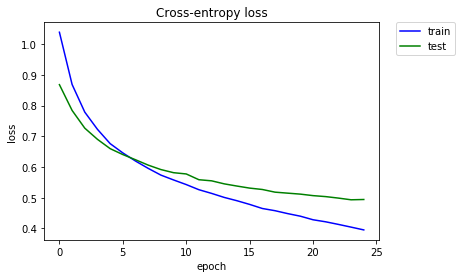

In [16]:
plot_losses(train_loss, test_loss)

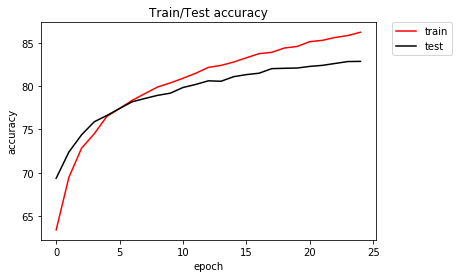

In [17]:
plot_accuracy(train_acc, test_acc)

In [18]:
def test_acccuracy(testloader, model):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = model(Variable(images).type(dtype))
        labels = Variable(labels).type(torch.cuda.LongTensor)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    acc = 100*correct/total
    print('Accuracy of the network on the 10000 test images: %d %%' % (acc))
    return acc

test_acccuracy(testloader, net)

Accuracy of the network on the 10000 test images: 82 %


82.88